In [2]:
import torch
import torch.autograd
from torch.autograd import Variable
from torch import autograd
import numpy as np
import os
import matplotlib.pyplot as plt
import time
import sys
sys.path.append(os.path.join(os.getcwd(), '..', 'utils'))
from compute_tau import compute_tau_star
import matplotlib.patches as mpatches
import seaborn as sns
sns.set()
sns.set_style("whitegrid",  {"grid.linewidth": 0.6})
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
figsize = (8, 6)
marker_list = ['o', 'v', 's', 'P', '*', 'X', 'D']
cmap = plt.get_cmap("tab10")
cmap2 = plt.get_cmap("tab20")
fig_dir = os.path.join(os.getcwd(), 'polynomial_nn_figs')
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
ss= 250
ms=15
ms2=20
ms3=.5
ls=20
fs=30
fs2=24
lsp=0.1
htp=.1
run_test=True
verbose=True
show=True
save=True
lw=4
frameon=False
# parameters of game function.
a = 1
b = 1.25

## Game and Derivatives

In [3]:
def f1_func(x, y, w, z):
    return (a*x**2+2*np.sqrt(a)*x*w + .5*a*w**2 - .5*y**2 + 2*np.sqrt(a)*y*z -a*z**2)*b*(x-1)**2 + x**2*((x-1)**2+(y-1)**2-(w-1)**2-(z-1)**2)

def f2_func(x, y, w, z):
    return -(a*x**2+2*np.sqrt(a)*x*w + .5*a*w**2 - .5*y**2 + 2*np.sqrt(a)*y*z -a*z**2)*b*(x-1)**2 - x**2*((x-1)**2+(y-1)**2-(w-1)**2-(z-1)**2)

def d1f1_func(x, y, w, z):
    return 2*(b*(x - 1)*(a*(0.5*w**2 + x**2 - z**2) + 2*np.sqrt(a)*(w*x + y*z) - 0.5*y**2) + b*(x - 1)**2*(np.sqrt(a)*w + a*x) + x*(-(w - 1)**2 + (x - 1)**2 + (y - 1)**2 - (z - 1)**2) + x**2*(x - 1)), 2*x**2*(y - 1) + b*(x - 1)**2*(2*np.sqrt(a)*z-y)

def d2f2_func(x, y, w, z):
    return -(b*(x - 1)**2*(a*w + 2*np.sqrt(a)*x) - 2*(w - 1)*x**2), -(b*(x - 1)**2 *(2*np.sqrt(a)*y - 2*a*z) - 2*x**2*(z - 1))

def d11f1_func(x, y, w, z):
    return None

def d21f2_func(x, y, w, z):    
    return None

def d12f1_func(x, y, w, z):    
    return None

def d22f2_func(x, y, w, z): 
    return None

def J_tau_func(x, y, w, z, tau):
    d11f1 = d11f1_func(x, y)
    d12f1 = d12f1_func(x, y)
    d21f2 = d21f2_func(x, y)
    d22f2 = d22f2_func(x, y)
    return np.array([[d11f1, d12f1], [tau*d21f2, tau*d22f2]])

if run_test:
    for test_num in range(500):
        x = np.random.randint(-20, 20)*np.random.rand()
        y = np.random.randint(-20, 20)*np.random.rand()
        w = np.random.randint(-20, 20)*np.random.rand()
        z = np.random.randint(-20, 20)*np.random.rand()

        x_torch = Variable(torch.Tensor([x]), requires_grad=True)
        y_torch = Variable(torch.Tensor([y]), requires_grad=True)
        w_torch = Variable(torch.Tensor([w]), requires_grad=True)
        z_torch = Variable(torch.Tensor([z]), requires_grad=True)

        assert np.allclose([torch.autograd.grad(f1_func(x_torch, y_torch, w_torch, z_torch), x_torch)[0].item(), torch.autograd.grad(f1_func(x_torch, y_torch, w_torch, z_torch), y_torch)[0].item()], np.array(d1f1_func(x, y, w, z)), 1e-3)
        assert np.allclose([torch.autograd.grad(f2_func(x_torch, y_torch, w_torch, z_torch), w_torch)[0].item(), torch.autograd.grad(f2_func(x_torch, y_torch, w_torch, z_torch), z_torch)[0].item()], np.array(d2f2_func(x, y, w, z)), 1e-3)

def jacobian_blocks(x, y, w, z):
    
    x_torch = Variable(torch.Tensor([x]), requires_grad=True)
    y_torch = Variable(torch.Tensor([y]), requires_grad=True)
    w_torch = Variable(torch.Tensor([w]), requires_grad=True)
    z_torch = Variable(torch.Tensor([z]), requires_grad=True)

    a11 = torch.autograd.grad(d1f1_func(x_torch, y_torch, w_torch, z_torch)[0], x_torch)[0].item()
    a12 = torch.autograd.grad(d1f1_func(x_torch, y_torch, w_torch, z_torch)[0], y_torch)[0].item()
    a21 = torch.autograd.grad(d1f1_func(x_torch, y_torch, w_torch, z_torch)[1], x_torch)[0].item()
    a22 = torch.autograd.grad(d1f1_func(x_torch, y_torch, w_torch, z_torch)[1], y_torch)[0].item()

    b11 = torch.autograd.grad(d1f1_func(x_torch, y_torch, w_torch, z_torch)[0], w_torch)[0].item()
    b12 = torch.autograd.grad(d1f1_func(x_torch, y_torch, w_torch, z_torch)[0], z_torch)[0].item()
    b21 = 0
    b22 = torch.autograd.grad(d1f1_func(x_torch, y_torch, w_torch, z_torch)[1], z_torch)[0].item()

    c11 = torch.autograd.grad(d2f2_func(x_torch, y_torch, w_torch, z_torch)[0], x_torch)[0].item()
    c12 = 0
    c21 = torch.autograd.grad(d2f2_func(x_torch, y_torch, w_torch, z_torch)[1], x_torch)[0].item()
    c22 = torch.autograd.grad(d2f2_func(x_torch, y_torch, w_torch, z_torch)[1], y_torch)[0].item()

    d11 = torch.autograd.grad(d2f2_func(x_torch, y_torch, w_torch, z_torch)[0], w_torch)[0].item()
    d12 = 0
    d21 = 0
    d22 = torch.autograd.grad(d2f2_func(x_torch, y_torch, w_torch, z_torch)[1], z_torch)[0].item()

    A = np.array([[a11, a12], [a21, a22]])
    B = np.array([[b11, b12], [b21, b22]])
    C = np.array([[c11, c12], [c21, c22]])
    D = np.array([[d11, d12], [d21, d22]])

    return A, B, C, D


# From mathematica; see compute_polynomial_critical_points.nb
critical_points = [[-4.73405, 0.277896, -92.4744, 0.532709], 
                    [0, 0, 0, 0], [1., 1., 1.,  1.]]
critical_points = np.array(critical_points)

## Run Dynamics

In [4]:
num_epochs = 20000
freq = 10000
learning_rate = 5e-4
tau_list = [0.75, 2, 5, 12]
x_init = -1
y_init =  2.5
w_init = 2.5
z_init = 3
learning_rule = 'simgrad'

trajectories = []

for tau in tau_list:

    trajectory = []
    x = x_init
    y = y_init
    w = w_init
    z = z_init

    v = np.array([x, w, y, z])

    trajectory.append(v)
    start = time.time()

    for epoch in range(1, num_epochs+1):

        d1f1 = d1f1_func(x, y, w, z)             
        d2f2 = d2f2_func(x, y, w, z)
        x = x - learning_rate * d1f1[0]
        y = y - learning_rate * d1f1[1]
        w = w - tau*learning_rate * d2f2[0]
        z = z - tau*learning_rate * d2f2[1]
        
        v = np.array([x, y, w, z])
        trajectory.append(v)

        if verbose:
            if epoch % freq == 0:
                print(epoch, v)

    trajectory = np.vstack(trajectory)
    trajectories.append(trajectory)

    end = time.time()

    if verbose:
        print('Finished in {:.2f} Seconds'.format(end-start))

10000 [-0.26947327 -0.00127675  0.42938236  0.02614236]
20000 [-0.01779109 -0.0027985   0.0067231  -0.00173134]
Finished in 0.46 Seconds
10000 [ 0.04499383 -0.00289465 -0.10046697 -0.00182921]
20000 [-0.0020218  -0.00136524 -0.0586037   0.0004356 ]
Finished in 0.46 Seconds
10000 [0.99999997 0.99965085 1.         1.        ]
20000 [1.         0.99999998 1.         1.        ]
Finished in 0.46 Seconds
10000 [1.        0.9999937 1.        1.       ]
20000 [1. 1. 1. 1.]
Finished in 0.46 Seconds


## Plot Trajectories

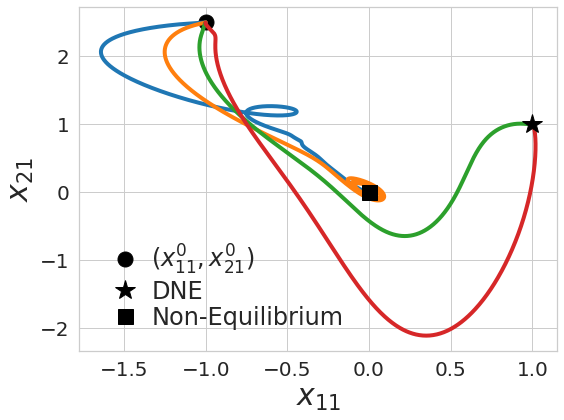

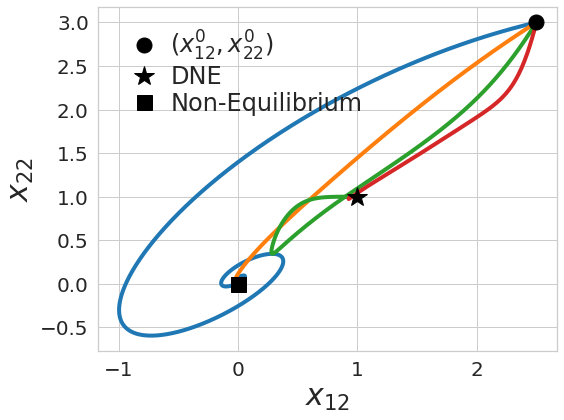

In [6]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
ax.plot(trajectory[0, 0], trajectory[0, 2], color='black', marker='o', markersize=ms, ls='none', label=r'$(x_{11}^{0}, x_{21}^{0})$')
for i, trajectory in enumerate(trajectories):
    ax.plot(trajectory[:, 0], trajectory[:, 2], color=cmap(i), lw=lw)
ax.plot(1, 1, color='black', marker='*', markersize=ms2, ls='none', label=r'DNE')
ax.plot(0, 0, color='black', marker='s', markersize=ms, ls='none', label=r'Non-Equilibrium')
ax.set_xlabel('$x_{11}$', fontsize=fs)
ax.set_ylabel('$x_{21}$', fontsize=fs)
ax.tick_params(labelsize=ls)
plt.legend(fontsize=fs2, labelspacing=lsp, frameon=frameon, handletextpad=htp, loc='best')
plt.tight_layout()
if save:
    plt.savefig(os.path.join(fig_dir, learning_rule+'_x1_y1.png'), bbox_inches='tight')
if show:
    plt.show()

fig, ax = plt.subplots(1, 1, figsize=figsize)
for i, trajectory in enumerate(trajectories):
    ax.plot(trajectory[:, 1], trajectory[:, 3], color=cmap(i), lw=lw)
ax.plot(trajectory[0, 1], trajectory[0, 3], color='black', marker='o', markersize=ms, ls='none', label=r'$(x_{12}^{0}, x_{22}^{0})$')
ax.plot(1, 1, color='black', marker='*', markersize=ms2, ls='none', label=r'DNE')
ax.plot(0, 0, color='black', marker='s', markersize=ms, ls='none', label=r'Non-Equilibrium')
ax.set_xlabel('$x_{12}$', fontsize=fs)
ax.set_ylabel('$x_{22}$', fontsize=fs)
ax.tick_params(labelsize=ls)
plt.legend(fontsize=fs2, labelspacing=lsp, frameon=frameon, handletextpad=htp, loc='best')
plt.tight_layout()
if save:
    plt.savefig(os.path.join(fig_dir, learning_rule+'_x2_y2.png'), bbox_inches='tight')
if show:
    plt.show()

## Plot Eigenvalues

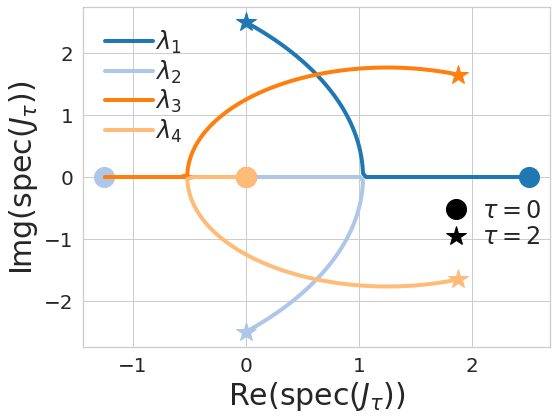

Schur Eigs [-2.5   1.25]
Follower Hessian Eigs [-1.25  2.5 ]


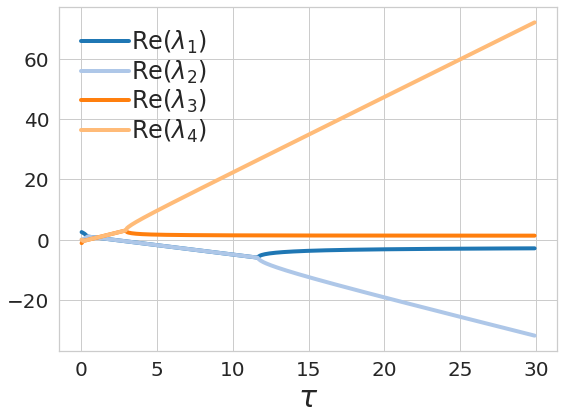

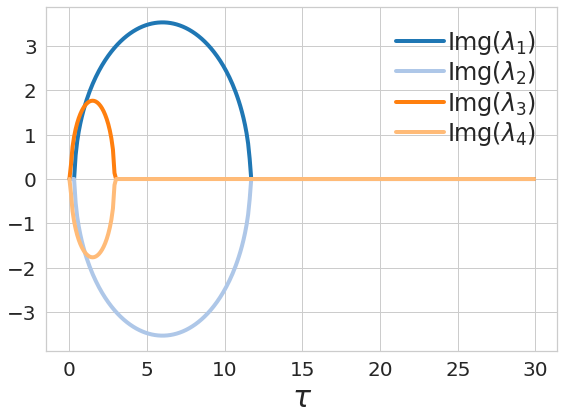

In [8]:
tau_min = 0
tau_max = 2
tau_step = .001

tau_sweep = np.arange(tau_min, tau_max, tau_step)
x,y,w,z = (0,0,0,0)

eigs = []
A, B, C, D = jacobian_blocks(x, y, w, z)
for tau in tau_sweep:    
    J_tau = np.vstack((np.hstack((A, B)), tau*np.hstack((C, D))))
    eigs.append(np.linalg.eigvals(J_tau))

eigs = np.vstack(eigs)

fig, ax = plt.subplots(1, 1, figsize=figsize)

for i in range(eigs.shape[1]):
    ax.plot(np.real(eigs[:, i]), np.imag(eigs[:, i]), '-', lw=lw, color=cmap2(i), markersize=ms3, label=r'$\lambda_%d$'%(i+1))
    ax.plot(np.real(eigs[0, i]), np.imag(eigs[0, i]), color=cmap2(i), marker='o', markersize=ms2)
    ax.plot(np.real(eigs[-1, i]), np.imag(eigs[-1, i]), color=cmap2(i), marker='*', markersize=ms2)

ax.set_ylabel(r'Img(spec($J_{\tau}$))', fontsize=fs)
ax.set_xlabel(r'Re(spec($J_{\tau}$))', fontsize=fs)
ax.tick_params(labelsize=ls)
legend1 = ax.legend(fontsize=fs2, labelspacing=lsp, frameon=frameon, handletextpad=htp)

l1, = ax.plot([], [], color='black', ls='none', marker='o', markersize=ms2)
l2, = ax.plot([], [], color='black', ls='none', marker='*', markersize=ms2)
legend2 = ax.legend([l1, l2], [r'$\tau=$'+str(tau_min), r'$\tau=$'+str(tau_max)], fontsize=fs2, labelspacing=lsp, frameon=frameon, handletextpad=htp, bbox_to_anchor=(.7, .5))

ax.add_artist(legend1)
plt.tight_layout()

if save:
    plt.savefig(os.path.join(fig_dir, 'tau_eig_sweep1.png'), bbox_inches='tight')
if show:
    plt.show()
    
tau_min = .01
tau_max = 30.
tau_step = .1

tau_sweep = np.arange(tau_min, tau_max, tau_step)
x,y,w,z = (0,0,0,0)

eigs = []
A, B, C, D = jacobian_blocks(x, y, w, z)
print('Schur Eigs', np.linalg.eigvals(A - B@np.linalg.inv(D)@C))
print('Follower Hessian Eigs', np.linalg.eigvals(D))
for tau in tau_sweep:    
    J_tau = np.vstack((np.hstack((A, B)), tau*np.hstack((C, D))))
    eigs.append(np.linalg.eigvals(J_tau))

eigs = np.vstack(eigs)

fig, ax = plt.subplots(1, 1, figsize=figsize)

for i in range(eigs.shape[1]):
    ax.plot(tau_sweep, np.real(eigs[:, i]), '-', lw=lw, color=cmap2(i), markersize=ms3, label=r'Re($\lambda_%d$)'%(i+1))

ax.set_xlabel(r'$\tau$', fontsize=fs)
ax.tick_params(labelsize=ls)
ax.legend(fontsize=fs2, labelspacing=lsp, frameon=frameon, handletextpad=htp)
plt.tight_layout()

if save:
    plt.savefig(os.path.join(fig_dir, 'tau_eig_sweep2.png'), bbox_inches='tight')
if show:
    plt.show()
    
    
fig, ax = plt.subplots(1, 1, figsize=figsize)

for i in range(eigs.shape[1]):
    ax.plot(tau_sweep, np.imag(eigs[:, i]), '-', lw=lw, color=cmap2(i), markersize=ms3, label=r'Img($\lambda_%d)$'%(i+1), ls='-')
ax.set_xlabel(r'$\tau$', fontsize=fs)
ax.tick_params(labelsize=ls)
ax.legend(fontsize=fs2, labelspacing=lsp, frameon=frameon, handletextpad=htp)
plt.tight_layout()

if save:
    plt.savefig(os.path.join(fig_dir, 'tau_eig_sweep3.png'), bbox_inches='tight')
if show:
    plt.show()

## Compute $\tau^{\ast}$

In [6]:
m = 2
n = 2

for critical_point in critical_points:
    x, y, w, z = critical_point
    A, B, C, D = jacobian_blocks(x, y, w, z)
    J = np.vstack((np.hstack((A, B)), np.hstack((C, D))))
    tau_star = compute_tau_star(J, m, n)
    if type(tau_star) is str:
        print('critical point (x_1, x_2, y_1, y_2) = ({:.2f}, {:.2f}, {:.2f}, {:.2f}):'.format(x, y, w, z), tau_star)
    else:
        print(r'tau = {:.2f}'.format(tau_star), '@ critical point (x_1, x_2, y_2, y_2) = ({:.2f}, {:.2f}, {:.2f}, {:.2f})'.format(x, y, w, z))

tau = 0.00 @ critical point (x_1, x_2, y_2, y_2) = (-4.73, 0.28, -92.47, 0.53)
critical point (x_1, x_2, y_1, y_2) = (0.00, 0.00, 0.00, 0.00): Given critical point is not a DSE so it fails to satisfy the theorem
tau = 0.00 @ critical point (x_1, x_2, y_2, y_2) = (1.00, 1.00, 1.00, 1.00)
